# Usage (details: theoretical datasets)
Here, we will create an example dataset with theoretical values of SIR-derived model. Then, we will perform scenario analysis with it.

## Preparation

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
from pprint import pprint

In [4]:
import covsirphy as cs
cs.__version__

'2.12.0-kappa.new.362.366.367.fix.360.373.solving.357.359'

In [5]:
# Instance to save population values
population_data = cs.PopulationData(filename=None)
population_data.cleaned()

,ISO3,Country,Province,Date,Population


## Create example dataset with theoretical values
We will use `ExampleData` class to produce theoretical values. Model descriptions (`SIR` class etc.) have preset of parameter values. Then, $\tau$ (coeficient for non-dimensionalization) will be set as $1440\ \mathrm{[min]}$. The first date of records will be 01Jan2020 as an example.

In [6]:
# Set tau value and start date of records
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


`ExampleData` class is a child class of `JHUData`. This means that we can use the example data in scenario analysis. Example codes will be shown in "Scenario analysis with theoretical data" subsection.

In [7]:
issubclass(cs.ExampleData, cs.JHUData)

True

In [8]:
isinstance(example_data, cs.JHUData)

True

## SIR model
Let's start with simle SIR model. Details of models are explained in [Kaggle: COVID-19 data with SIR model](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#SIR-to-SIR-F).
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

Note:  
Though R in SIR model is "Recovered and have immunity", We defines "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

In [9]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


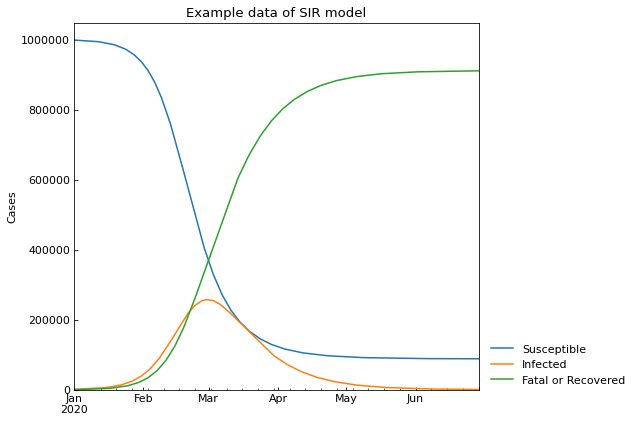

In [10]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

In [11]:
# Model name
print(cs.SIRD.NAME)
# Example parameter values
pprint(cs.SIRD.EXAMPLE, compact=True)

SIR-D
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


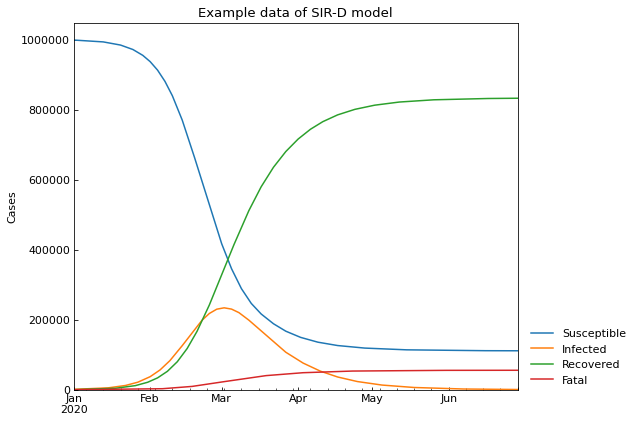

In [12]:
model = cs.SIRD
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SIR-F model
It is reported that some cases died before clinical diagnosis of COVID-19. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model. When $\alpha_{1}=0$, SIR-F model will be the same as SIR-D model.
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

In [13]:
# Model name
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


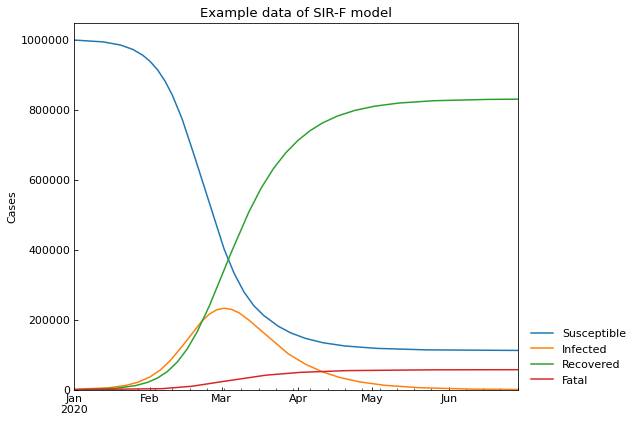

In [14]:
model = cs.SIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SEWIR-F model (SIR-F with exposed/waiting cases)
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S$\overset{\beta I}{\longrightarrow}$S$^\ast$ as follows because W also has infectivity.
\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

In [15]:
# Model name
print(cs.SEWIRF.NAME)
# Example parameter values
pprint(cs.SEWIRF.EXAMPLE, compact=True)

SEWIR-F
{'param_dict': {'kappa': 0.005,
                'rho1': 0.2,
                'rho2': 0.167,
                'rho3': 0.167,
                'sigma': 0.075,
                'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Exposed': 3000,
             'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 994000,
             'Waiting': 0.002}}


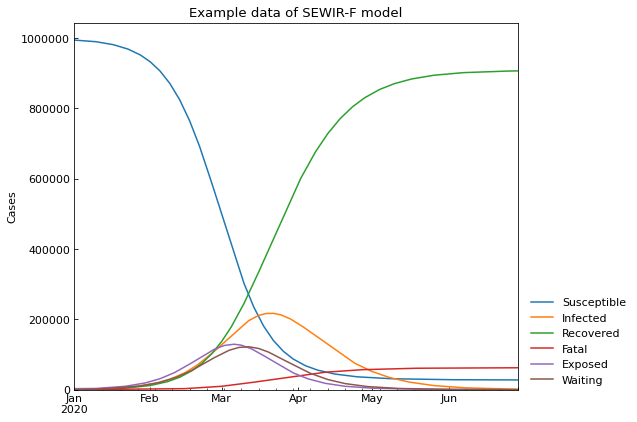

In [16]:
model = cs.SEWIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SIR-FV model (SIR-F model with vaccination)
This model considers vacctnation of sussceptible people as follows. $\omega \times N$ persons will be vaccinated in a day. $N$ is the total population.
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

With
$$
\frac{\mathrm{d}S}{\mathrm{d}T}= - \beta S I - \omega N  \\
$$

In [17]:
# Model name
print(cs.SIRFV.NAME)
# Example parameter values
pprint(cs.SIRFV.EXAMPLE, compact=True)

SIR-FV
{'param_dict': {'kappa': 0.005,
                'omega': 0.001,
                'rho': 0.2,
                'sigma': 0.075,
                'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000,
             'Vaccinated': 0}}


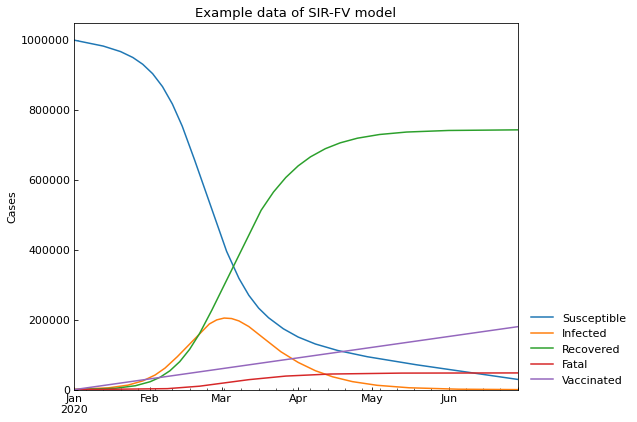

In [18]:
model = cs.SIRFV
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## Scenario analysis with theoretical data
Because `ExampleData` class is a subclass of `JHUData`, we can perform scenario analysis with example datasets easily. Here, we will use the following scenarios. For explanation, $\tau=1440$, the start date is 01Jan2020, population is 1,000,000 and country name is "Theoretical". This is not based on actual data.

| name | 01Jan2020 - 31Jan2020 | 01Feb2020 - 31Dec2020 |
|:---:|:---:|:---|
| Main | SIR-F | SIR-F|
| Lockdown | SIR-F | SIR-F with half value of $\rho$ |
| Medicine | SIR-F | SIR-F with half value of $\kappa$ and double value of $\sigma$ |
| Vaccine | SIR-F | SIR-FV with $\omega=0.01$|

In [19]:
# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
preset_dict

{'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}

In [20]:
area = {"country": "Theoretical"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)
# Register population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
population_data.value(**area)

1000000

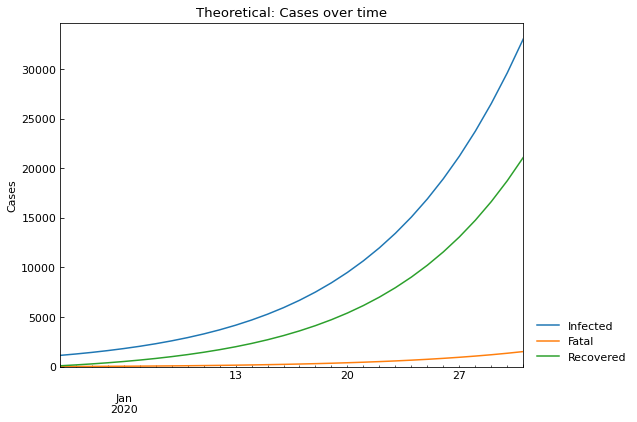

,Date,Confirmed,Infected,Fatal,Recovered
0,2020-01-02,1213,1127,6,80
1,2020-01-03,1451,1270,12,169
2,2020-01-04,1720,1430,19,271
3,2020-01-05,2025,1612,28,385
4,2020-01-06,2366,1816,37,513


,Date,Confirmed,Infected,Fatal,Recovered
25,2020-01-27,35218,21210,940,13068
26,2020-01-28,39544,23730,1061,14753
27,2020-01-29,44357,26524,1196,16637
28,2020-01-30,49704,29616,1347,18741
29,2020-01-31,55633,33030,1515,21088


In [21]:
# Show records with Scenario class
snl = cs.Scenario(example_data, population_data, tau=1440, **area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())

Note:  
Record on 01Jan2020 was removed because the number of recovered cases is 0 and this sometimes causes error in estimation.

In [22]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
0th,Past,02Jan2020,31Jan2020,1000000,SIR-F,2.5,0.002,0.005,0.2,0.075,1440,0.002,200,5,13


In [23]:
# Add main scenario
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
snl.clear(name="Lockdown")
rho_lock = snl.get("rho", phase="0th") / 2
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_lock)
# Add medicine scenario
snl.clear(name="Medicine")
kappa_med = snl.get("kappa", phase="0th") / 2
sigma_med = snl.get("sigma", phase="0th") * 2
snl.add(end_date="31Dec2020", name="Medicine", kappa=kappa_med, sigma=sigma_med)
# Add vaccine scenario
snl.clear(name="Vaccine")
snl.add(end_date="31Dec2020", name="Vaccine", model=cs.SIRFV, omega=0.01)
# Summarize
snl.summary()

Type      Start        End  Population     ODE   Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.5  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-FV  2.5  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.5  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-FV  2.5  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.5  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-FV  2.5  0.002   
Vaccine  0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.5  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-FV  2.5  0.002   

                kappa  rho  sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                        
Main     0th    0.005  0.2  0.075  1440       0.002             200   
         1st    0.005  0.2  0.075  1440       0.002             200   
Lockdown 0th    0.005  0.2  0.075  1440       0.002             200   
         1st    0.005  0.2  0.075  1440       0.002             200   
Medicine 0th    0.005  0.2  0.075  1440       0.002             200   
         1st    0.005  0.2  0.075  1440       0.002             200   
Vaccine  0th    0.005  0.2  0.075  1440       0.002             200   
         1st    0.005  0.2  0.075  1440       0.002             200   

                1/beta [day]  1/gamma [day] omega Vaccinated [persons/day]  
Scenario Phase                                                              
Main     0th               5             13     -                        -  
         1st               5             13  0.01                    10000  
Lockdown 0th               5             13     -                        -  
         1st               5             13  0.01                    10000  
Medicine 0th               5             13     -                        -  
         1st               5             13  0.01                    10000  
Vaccine  0th               5             13     -                        -  
         1st               5             13  0.01                    10000

### Compare the scenarios

In [24]:
# Apply initial value of Vaccinated because this variable is not included in first model (SIR-F)
snl.describe(y0_dict={"Vaccinated": 0})

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021
Main,36797,01Feb2020,62209,0,4003
Lockdown,36797,01Feb2020,62209,0,4003
Medicine,36797,01Feb2020,62209,0,4003
Vaccine,36797,01Feb2020,62209,0,4003


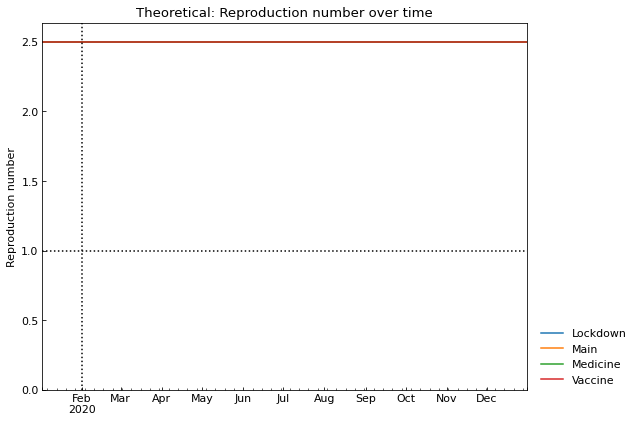

In [25]:
_ = snl.history(target="Rt")

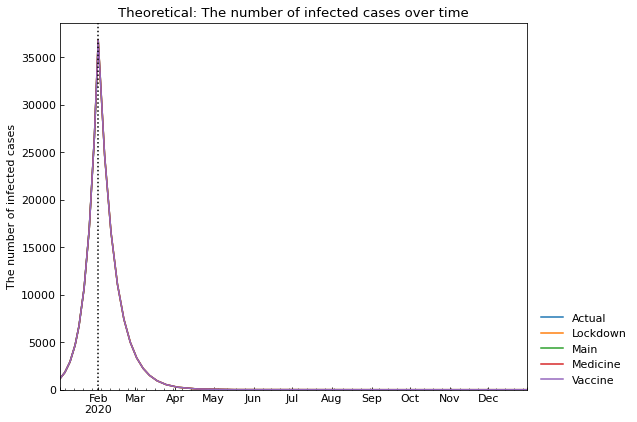

In [26]:
_ = snl.history(target="Infected")

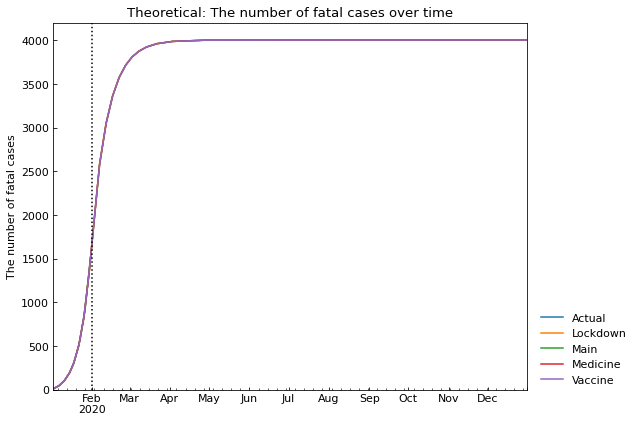

In [27]:
_ = snl.history(target="Fatal")

### Simulation of each scenario

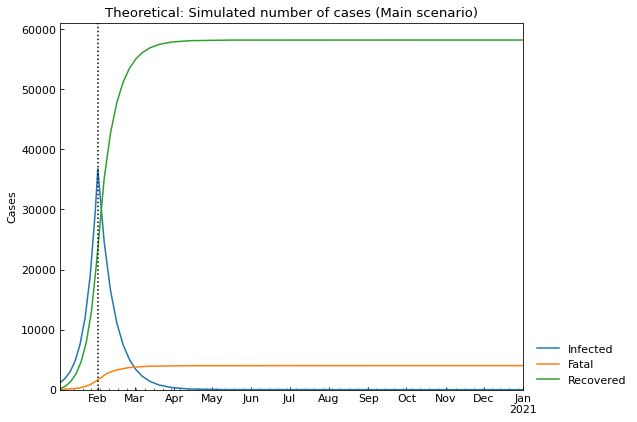

In [28]:
_ = snl.simulate(name="Main")

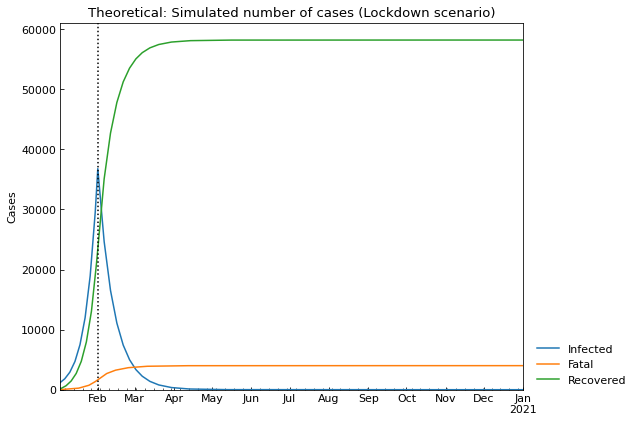

In [29]:
_ = snl.simulate(name="Lockdown")

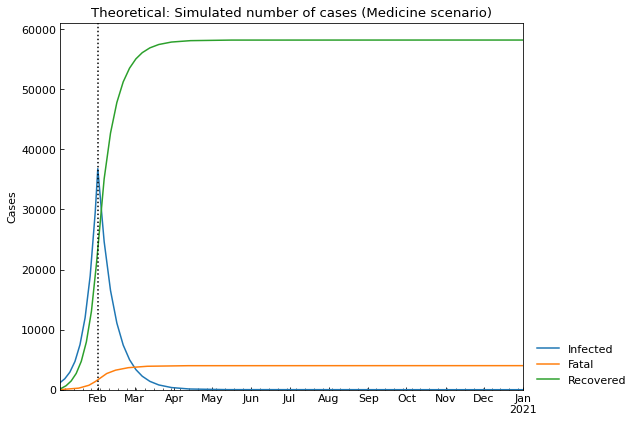

In [30]:
_ = snl.simulate(name="Medicine")

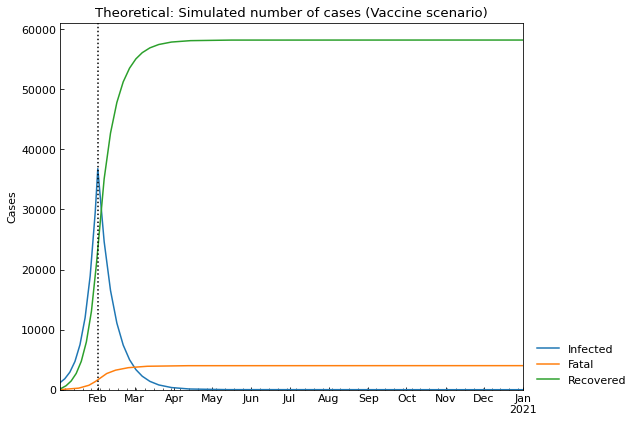

In [31]:
_ = snl.simulate(name="Vaccine", y0_dict={"Vaccinated": 0})